In [1]:
from tools import vis

import json, imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx
#from networkx.drawing.nx_agraph import graphviz_layout as layout
from networkx.drawing.layout import spring_layout as layout

def bipartite_graph_from_edges(E):
    G = nx.Graph()
    for i, U in enumerate(E.T):
        G.add_nodes_from(U, bipartite=i)
    G.add_edges_from(E.tolist())

    return G

def largest_cycle(G):
    basis = nx.cycle_basis(G)
    return max(map(len, basis)) if len(basis) else 2

def safe_diameter(G):
    return max(map(nx.diameter, nx.connected_component_subgraphs(G)))

default_metrics = [
    nx.number_of_nodes,
    nx.degree_assortativity_coefficient,
    largest_cycle,
    safe_diameter
]

def get_graph_repr(X, metrics=default_metrics):
    return X.apply(lambda G: pd.Series({m.__name__: m(G) for m in metrics})).fillna(0)

# Load the data
This is a list of co-occurrences in Les Miserables. For example, charater *MY* was present in Volume 1, Book 1, Chapter 1, and Scene 0.

In [3]:
with open('./processed/lesmis.json') as fp:
    obj = json.load(fp)
    df = pd.DataFrame(**obj['X'])
    
df.head()

,Volume,Book,Chapter,Scene,Step,Characters
0,1,1,1,0,0,MY
1,1,1,1,0,0,NP
2,1,1,1,1,1,MY
3,1,1,1,1,1,MB
4,1,1,2,0,2,MY


# Modeling
Aggregate by volume, book, chapter and build a bipartite graph

In [4]:
# aggregate the graph data
by = [
    'Volume',
    'Book',
    'Chapter' # try commenting out this line
]

# builds a bipartite graph where characers and scenes are nodes
# an alternative is to build a co-occurrence graph with just characters

X_graph = df.groupby(by)\
    .apply(lambda df: bipartite_graph_from_edges(df[['Step', 'Characters']].values))

# Feature Engineering
Run some standard graph-level statistics on each graph

In [5]:
X_graph_stats = get_graph_repr(X_graph)

X_graph_stats.head()

degree_assortativity_coefficient  largest_cycle  \
Volume Book Chapter                                                    
1      1    1                               -0.333333            2.0   
            2                               -0.333333            2.0   
            3                                0.000000            2.0   
            4                               -0.111111            2.0   
            5                               -1.000000            2.0   

                     number_of_nodes  safe_diameter  
Volume Book Chapter                                  
1      1    1                    5.0            4.0  
            2                    5.0            4.0  
            3                    2.0            1.0  
            4                   11.0            4.0  
            5                    4.0            2.0

# Project into 2-D
Normalizes the graph stats and uses PCA

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

pos = pd.DataFrame(Pipeline([
    ('scale', StandardScaler()),
    ('proj', PCA(n_components=2))
]).fit_transform(X_graph_stats), index=X_graph_stats.index)

# Visualize

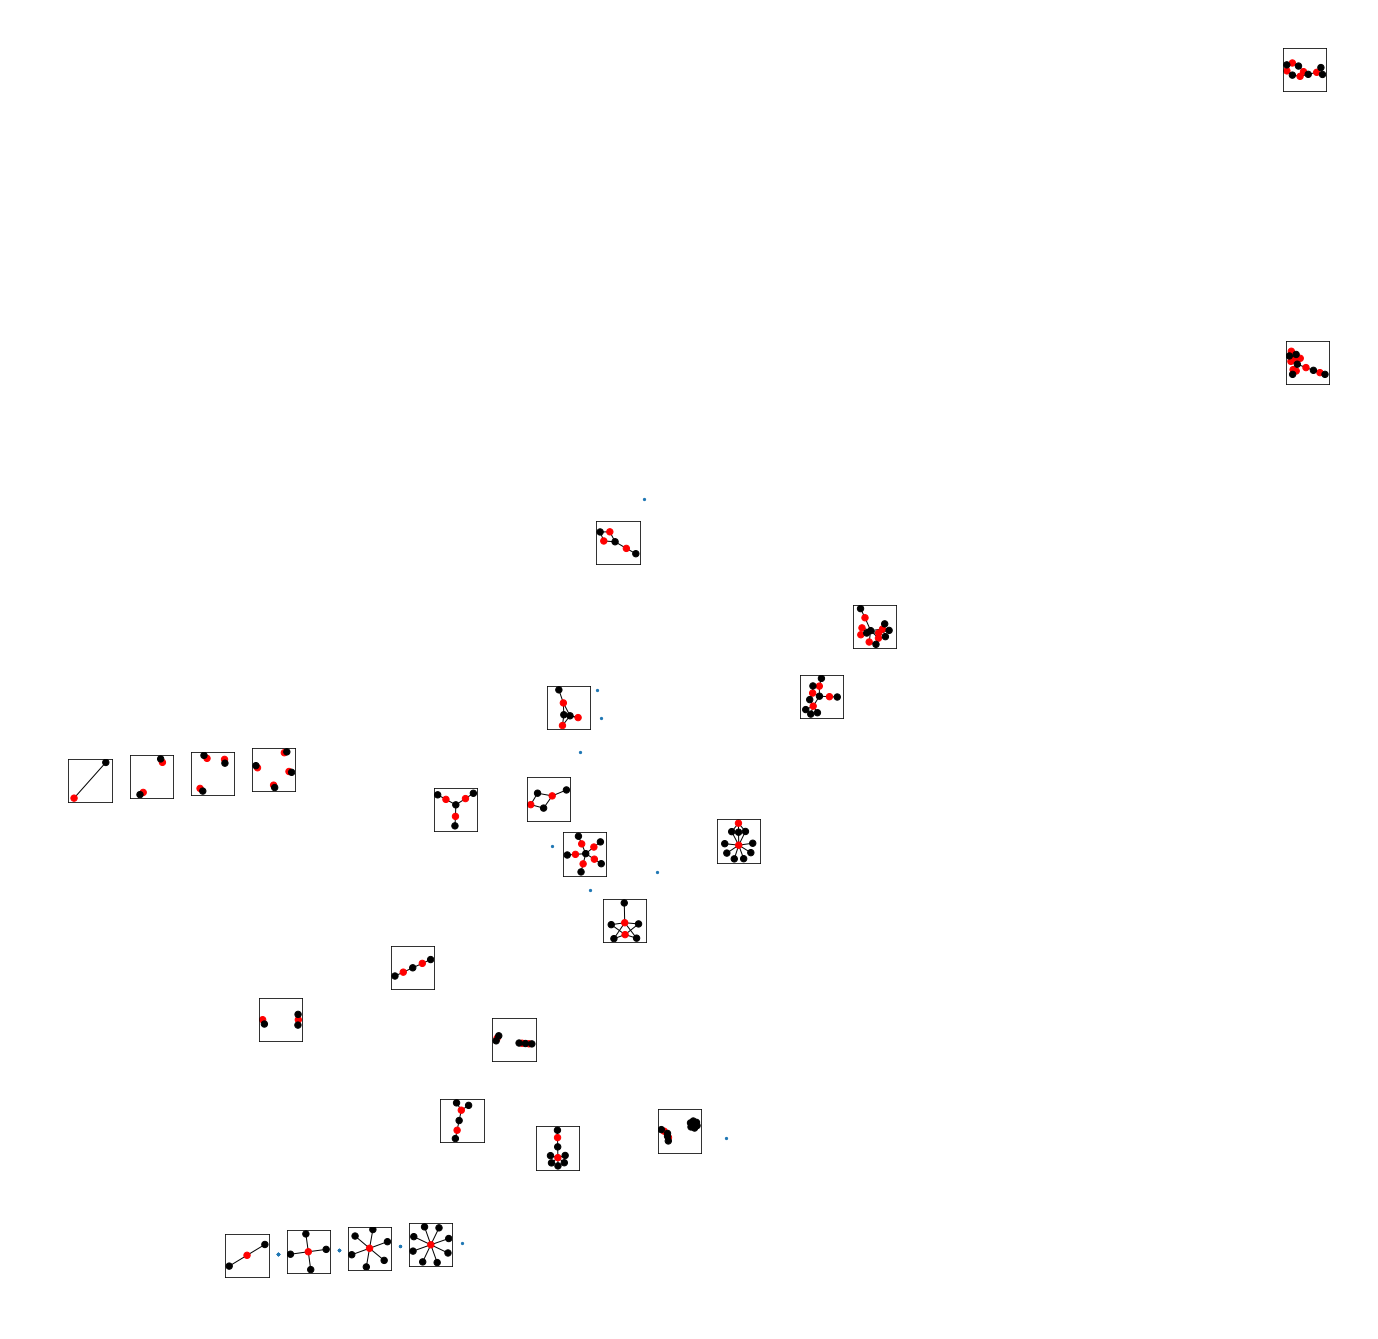

In [7]:
from matplotlib.colors import rgb2hex

# draw scenes as red dots, characters as black dots
node_colors = np.array(['red', 'black'])

plt.figure(figsize=(24, 24))
plt.axis('off')
for x, ax in vis.subplots_scatter(pos, s=.025, scatter_args=dict(s=5)):
    t = x[0]
    G = X_graph.loc[t]

    nx.draw_networkx(G, pos=layout(G),
                     node_color=node_colors[[d['bipartite'] for _,d in G.nodes(data=True)]],
                     edge_color='k',
                     node_size=40, ax=ax,
                     with_labels=False)
    plt.axis('equal')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

# Load the data
Some post-processing is necessary

In [8]:
with open('./processed/vast2014email.json') as fp:
    obj = json.load(fp)
    df = pd.DataFrame(**obj['X'])
    df['Date'] = pd.DatetimeIndex(df.Date)

In [9]:
df.head()

,From,To,Date,Subject
0,Sven.Flecha@gastech.com.kronos,"[Isak.Baza@gastech.com.kronos, Lucas.Alcazar@g...",2014-01-06 08:39:00,GT-SeismicProcessorPro Bug Report
1,Kanon.Herrero@gastech.com.kronos,"[Felix.Resumir@gastech.com.kronos, Hideki.Coci...",2014-01-06 08:58:00,Inspection request for site
2,Bertrand.Ovan@gastech.com.kronos,"[Emile.Arpa@gastech.com.kronos, Varro.Awelon@g...",2014-01-06 09:28:00,New refueling policies - Effective February 1
3,Valeria.Morlun@gastech.com.kronos,"[Dante.Coginian@gastech.com.kronos, Albina.Haf...",2014-01-06 09:38:00,Route suggestion for next shift
4,Mat.Bramar@gastech.com.kronos,"[Rachel.Pantanal@gastech.com.kronos, Lars.Azad...",2014-01-06 09:49:00,Upcoming birthdays


# Graph Modeling
Build a bipartite graph for each day.

In [10]:
def get_ego_networks(df, freq='d', hops=1):
    senders = df.From.unique()
    
    data = []
    index = []

    for t, dft in df.groupby(pd.Grouper(key='Date', freq=freq)):
        
        G = nx.DiGraph()

        for u, V, _, s in dft.values:
            G.add_node(s, bipartite=0)
            G.add_node(u, bipartite=1)
            G.add_edge(u, s)

            for v in V:
                G.add_node(v, bipartite=1)
                G.add_edge(s, v)
        
        for v in senders:
            if v in G:
                Gi = nx.ego_graph(G, v, radius=2*hops)
                if len(Gi) > 1:
                    data.append(dict(Date=t, From=v, G=Gi))
                
    return pd.DataFrame(data).set_index(['Date', 'From'], append=False).G

X_graph = get_ego_networks(df)

X_graph.head()

Date        From                             
2014-01-06  Sven.Flecha@gastech.com.kronos       (GT-SeismicProcessorPro Bug Report, Sven.Flech...
            Kanon.Herrero@gastech.com.kronos     (Inspection request for site, Kanon.Herrero@ga...
            Bertrand.Ovan@gastech.com.kronos     (New refueling policies - Effective February 1...
            Valeria.Morlun@gastech.com.kronos    (Dante.Coginian@gastech.com.kronos, Albina.Haf...
            Mat.Bramar@gastech.com.kronos        (Sven.Flecha@gastech.com.kronos, Isak.Baza@gas...
Name: G, dtype: object

# Feature Engineering
Run some standard graph-level statistics on each graph

In [11]:
X_graph_stats = get_graph_repr(X_graph.apply(nx.to_undirected))
X_graph_stats.head()

degree_assortativity_coefficient  \
Date       From                                                                  
2014-01-06 Sven.Flecha@gastech.com.kronos                            -0.830508   
           Kanon.Herrero@gastech.com.kronos                          -0.703971   
           Bertrand.Ovan@gastech.com.kronos                          -1.000000   
           Valeria.Morlun@gastech.com.kronos                         -0.917245   
           Mat.Bramar@gastech.com.kronos                             -0.912380   

                                              largest_cycle  number_of_nodes  \
Date       From                                                                
2014-01-06 Sven.Flecha@gastech.com.kronos               4.0              6.0   
           Kanon.Herrero@gastech.com.kronos             4.0             15.0   
           Bertrand.Ovan@gastech.com.kronos             4.0             16.0   
           Valeria.Morlun@gastech.com.kronos            2.0             11.0   
           Mat.Bramar@gastech.com.kronos                4.0             57.0   

                                              safe_diameter  
Date       From                                              
2014-01-06 Sven.Flecha@gastech.com.kronos               2.0  
           Kanon.Herrero@gastech.com.kronos             4.0  
           Bertrand.Ovan@gastech.com.kronos             2.0  
           Valeria.Morlun@gastech.com.kronos            4.0  
           Mat.Bramar@gastech.com.kronos                3.0

# Project into 2-D
Normalizes the graph stats and uses PCA

In [12]:
pos = pd.DataFrame(Pipeline([
    ('scale', StandardScaler()),
    ('proj', PCA(n_components=2))
]).fit_transform(X_graph_stats), index=X_graph_stats.index)

# Visualize

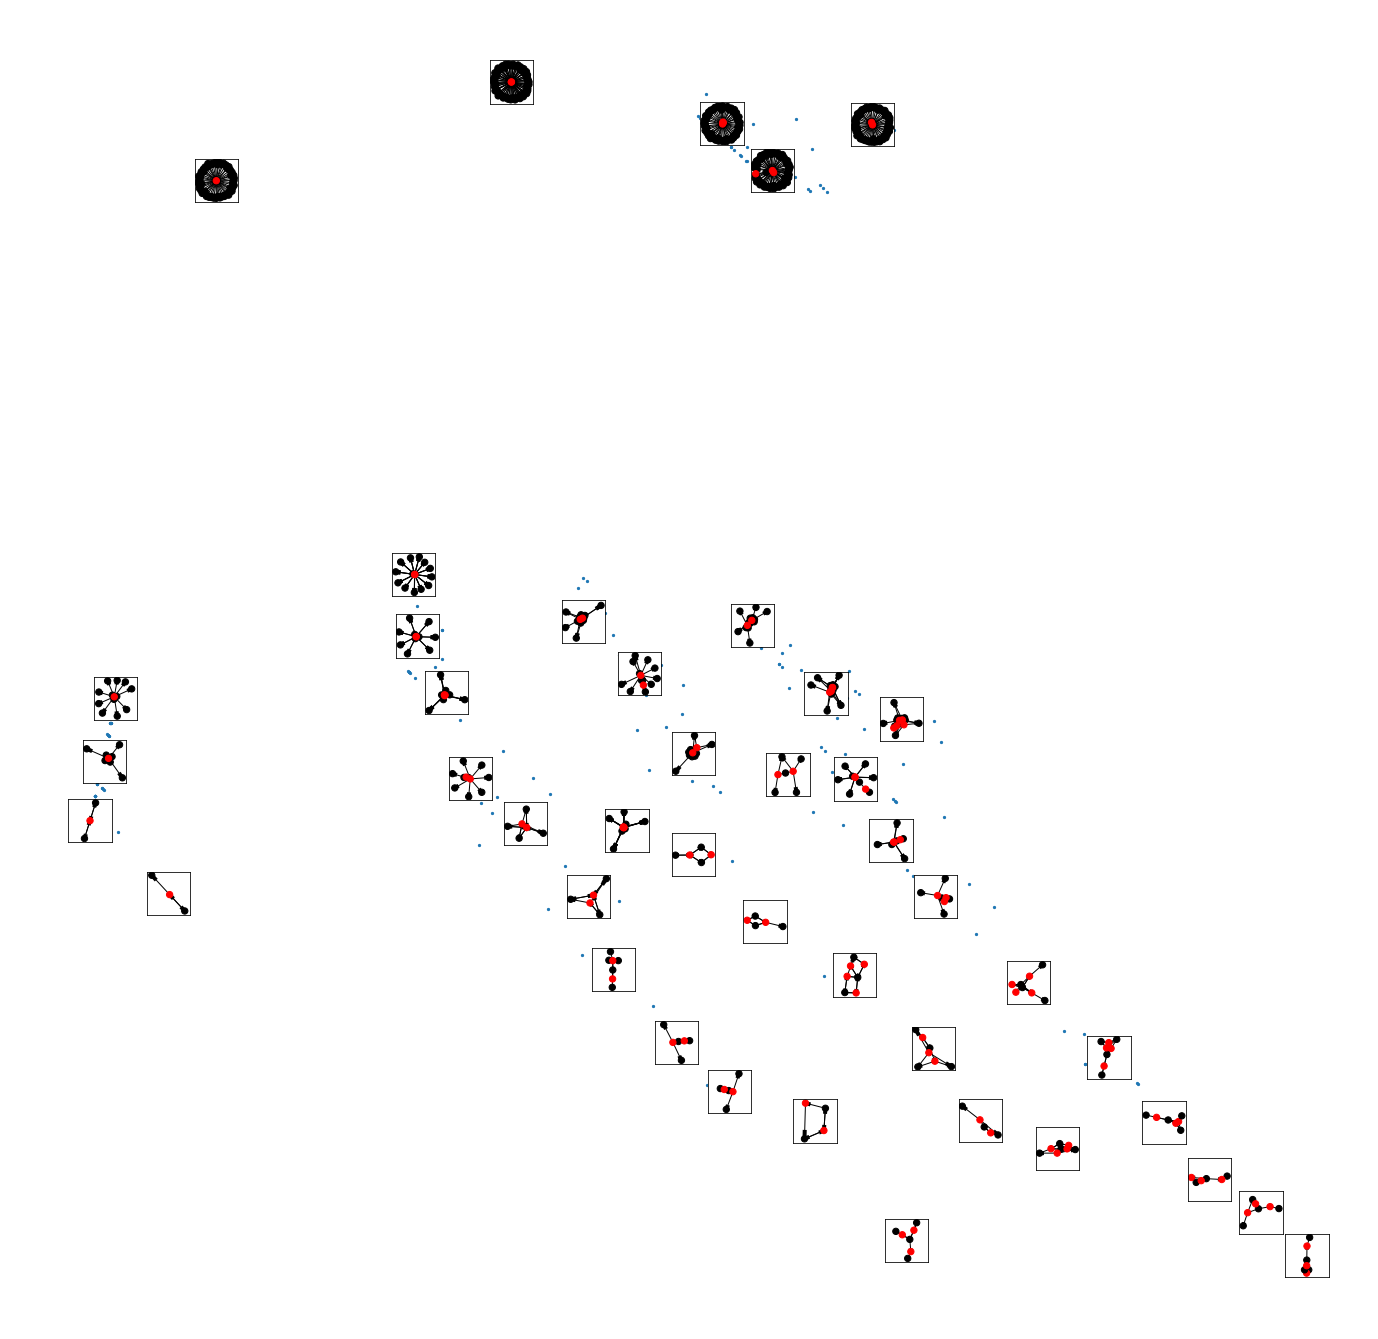

In [13]:
from matplotlib.colors import rgb2hex

# draw scenes as red dots, characters as black dots
node_colors = np.array(['red', 'black'])

plt.figure(figsize=(24, 24))
plt.axis('off')
for x, ax in vis.subplots_scatter(pos, s=.025, scatter_args=dict(s=5)):
    t = x[0]
    G = X_graph.loc[t]

    nx.draw_networkx(G, pos=layout(G),
                     node_color=node_colors[[d['bipartite'] for _,d in G.nodes(data=True)]],
                     edge_color='k',
                     node_size=40, ax=ax,
                     with_labels=False)
    plt.axis('equal')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

# Ideas for Exploration
* Try different levels of aggregation
* Try different graph modeling, e.g., co-occurrance instead of bipartite
* Try different graph statistics for features
* Try a different feature representation, e.g., embedding characters instead of the whole graph
* Try defining and implementing a classification task
